\noindent __Erwann Rault__  
_Centre Oscar Lambret (Lille)_

In [1]:
# DRAW MATPLOTLIB IN NOTEBOOK #

%matplotlib inline
# %matplotlib notebook


In [2]:
# LIBRARIES #

import numpy as np
import dicom as dcm
import matplotlib.pyplot as plt
import math
import time
import datetime

from scipy import ndimage
from ipywidgets import *

from IPython import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from os.path import basename

import warnings
warnings.filterwarnings('ignore')


In [3]:
# INPUT VARIABLES #

#fileDialog = QtGui.QFileDialog()
#filepath = fileDialog.getOpenFileName()

#filepath = './I123 tomo suv/SUV LEHR/recons noFilt/TOMO1SUV_EM_IRNC001_DS.dcm'
#filepath = './I123 tomo suv/SUV LEHR/recons ATT noFilt/TOMO1SUV_EM_IRAC001_DS.dcm'
#filepath = './I123 tomo suv/SUV LEHR/recons std ATT Butt/TOMO1SUV_EM_IRAC001_DS.dcm'
#filepath = './I123 tomo suv/SUV LEHR/recons SC ATT Butt/TOMO1SUV_EM_IRACSC001_DS.dcm'

filepath = 'X:/Med Nuc/etudes/SUVcalFactor_D670/Tc99m tomo/Tc99m tomo no1/QMetrix/TMAACLIN1.col.b4b7.colS1.1604599.1_00000.DCM'

Ainj = 75.48 #MBq
Tinj = datetime.datetime(2016,9,14,15,14,0)

Ares = 0.0 #MBq
Tres = datetime.datetime(2016,9,14,15,16,0)

# CSTES #
T1demi_Tc99m = 6.0058
T1demi_I123 = 13.22
T1demi_I131 = 192.48

nb_detectors = 2       # valeur fausse dans dicom header (reconstruction?)
scan_arc = 360         # valeur fausse dans dicom header
nb_angular_steps = 60  # valeur fausse dans dicom header
angular_step = 6       # valeur fausse dans dicom header

isotopeName = "Tc99m"
T1demi = T1demi_Tc99m # hours, half life from the isotope
margeROI = 10 #pix
thresholdPhantom = 0.2

# Acquisition information

In [4]:
# READS THE DICOM FILE #

ds = dcm.read_file(filepath)

In [5]:
# CONVERT DICOM TIME INFO TO DATETIME #

def convertToDatetime(date, time):
    year = int(int(date)/10000)
    month = int(int(date)/100-year*100)
    day = int(int(date)-year*10000-month*100)
    hour = int(float(time)/10000)
    minute = int(float(time)/100-hour*100)
    seconds =  int(float(time)-minute*100-hour*10000)
    return datetime.datetime(year, month, day, hour, minute, seconds)

In [6]:
# GET RELEVANT INFORMATION FROM DICOM FILE #

patient_name = ds.PatientName

study_date = ds.StudyDate
scan_time = ds[0x0008,0x0032].value
acq_datetime = convertToDatetime(study_date,scan_time)

try:
    rescaleIntercept = ds[0x0028,0x1052].value
    rescaleSlope = ds[0x0028,0x1053].value
except KeyError:
    rescaleIntercept = 0
    rescaleSlope = 1
    
#nb_detectors = ds.NumberOfDetectors
nb_slices = ds[0x0054,0x0081].value
nb_pixel_x = ds[0x0028,0x0011].value
nb_pixel_y = ds[0x0028,0x0010].value
nb_energy_win = ds.NumberOfEnergyWindows
#scan_arc = ds[0x0054,0x0052][0][0x0018,0x1143].value
#angular_step = ds[0x0054,0x0052][0][0x0018,0x1144].value
#nb_angular_steps = ds[0x0054,0x0052][0][0x0054,0x0053].value
frame_duration = int(ds[0x0054,0x0052][0][0x0018,0x1242].value/1000)
recons_corrections = ds[0x0028,0x0051].value

print "Patient name: ", patient_name
print "Patient ID: ", ds[0x0020,0x0010].value
print "File name:", basename(filepath)
print " "
print "Injected Isotope: ", isotopeName, "(half life:", T1demi,"h)"
print "Injected activity: ", Ainj, " MBq @ ", Tinj
print "Residual activity: ", Ares, " MBq @ ", Tres
print " "
print "Scan date and time: ", acq_datetime
print "Scan duration: ", frame_duration*nb_angular_steps, "s"
print "Nb of energy windows: " + str(nb_energy_win)
print "Nb of detectors: " + str(nb_detectors)
print "Image size: {0} x {1} x {2}" .\
                format(nb_pixel_x, nb_pixel_y, nb_slices)
print "Rescale slope:", rescaleSlope
print "Rescale intercept:", rescaleIntercept
print "Rotation of detectors: ", scan_arc
print "Angular step: ", angular_step, "deg"
print "Nb of steps: ", nb_angular_steps
print "Step duration: ", frame_duration, "s"
print "reconstruction corrections:", recons_corrections
print " "
print "Camera: ", ds[0x0008,0x0070].value
print "        ", ds[0x0008,0x1010].value
print "Collimator name: ", ds[0x0054,0x0022][0][0x0018,0x1180].value
print "Collimator type: ", ds[0x0054,0x0022][0][0x0018,0x1181].value
print "Zoom factor: ", ds[0x0054,0x0022][0][0x0028,0x0031].value

Patient name:  zzz_sensitivityD670
Patient ID:  Tomo
File name: TMAACLIN1.col.b4b7.colS1.1604599.1_00000.DCM
 
Injected Isotope:  Tc99m (half life: 6.0058 h)
Injected activity:  75.48  MBq @  2016-09-14 15:14:00
Residual activity:  0.0  MBq @  2016-09-14 15:16:00
 
Scan date and time:  2016-04-06 18:04:54
Scan duration:  300 s
Nb of energy windows: 1
Nb of detectors: 2
Image size: 256 x 256 x 181
Rescale slope: 1
Rescale intercept: 0
Rotation of detectors:  360
Angular step:  6 deg
Nb of steps:  60
Step duration:  5 s
reconstruction corrections: ATTN
 
Camera:  GE MEDICAL SYSTEMS, NUCLEAR
         XELERIS2
Collimator name:  LEHR
Collimator type:  PARA
Zoom factor:  ['1.000000', '1.000000']


In [7]:
# ENERGY WINDOWS #

#print ds[0x0054,0x0012][0]
#print ds[0x0054,0x0012][1]

# inline function to compute the energy mean and width of the energy windows (lambda function)
mk_energy_dict = lambda x,y:{(x+y)/2:round(np.abs(float(x)-float(y)),2)}

# creation of the dictionary
energy_list = list()
for el in range(nb_energy_win):
    energy_list.append(
        (mk_energy_dict(
            ds[0x0054,0x0012][el][0x0054,0x0013][0][0x0054,0x0014].value, 
            ds[0x0054,0x0012][el][0x0054,0x0013][0][0x0054,0x0015].value),el)
    )

print " Energy windows found:"
for i in energy_list:    
    print "   -> ", i

 Energy windows found:
   ->  ({140.5: 28.1}, 0)


# SUV calibration factor

In [8]:
# LAYOUT DEFINITIONS #

box_layout_std = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-start',
                    width='100%')

box_layout_right = Layout(display='flex',
                    flex_flow='row wrap',
                    justify_content='flex-end',
                    border='solid 0.5px #EEE',
                    width='100%')


In [9]:
# FINDS THE SUV PHANTOM IN THE IMAGE #

# function to find the phantom dimension and center in the image
def findPhantom(img, dimx, dimy, dimz, tp):
    #com = ndimage.measurements.center_of_mass(img)
    com = ndimage.measurements.maximum_position(img)

    maxx = ndimage.measurements.maximum(img[com[0],com[1],:])
    x1 = 0
    while (img[com[0],com[1],x1]<maxx*tp):
        x1 = x1+1
    x2 = dimx-1
    while (img[com[0],com[1],x2]<maxx*tp):
        x2 = x2-1
    x1=x1-1
    x2=x2+1
    
    maxy = ndimage.measurements.maximum(img[com[0],:,com[2]])
    y1 = 0
    while (img[com[0],y1,com[2]]<maxy*tp):
        y1 = y1+1
    y2 = dimy-1
    while (img[com[0],y2,com[2]]<maxy*tp):
        y2 = y2-1
    y1=y1-1
    y2=y2+1

    maxz = ndimage.measurements.maximum(img[:,com[1],com[2]])
    z1 = 0
    while (img[z1,com[1],com[2]]<maxz*tp):
        z1 = z1+1
    z2 = dimz-1
    while (img[z2,com[1],com[2]]<maxz*tp):
        z2 = z2-1
    z1=z1-1
    z2=z2+1
    
    centerx = int(x1+(x2-x1)/2)
    centery = int(y1+(y2-y1)/2)
    centerz = int(z1+(z2-z1)/2)
    
    if ((y2-y1)>(x2-1)):
        radius =(y2-y1)/2
    else:
        radius = (x2-x1)/2
    length = z2-z1

    return [centerx, centery, centerz, radius, length]


In [10]:
# FUNCTION TO CALC THE NB OF COUNTS IN THE IMAGE INSIDE THE ROI #

def calc_nbOfCounts(img, dimx, dimy, dimz, centerx, centery, centerz, r, h):
    nbcnts = 0
    for k in range(int(centerz-h/2), int(centerz+h/2)):
        for j in range(0, dimy):
            for i in range(0, dimx):
                if (math.sqrt((i-centerx)*(i-centerx)+(j-centery)*(j-centery))<=r):
                    nbcnts = nbcnts + img[k,j,i]
                    #m_img[k,j,i] = 0
                    
    return nbcnts

In [11]:
# SUV FACTOR CALCULATION #

def calcSUVfactor(nbcnts, a0, t0, ares, tres, tscan, duration, T, nbHeads, scanAngle):
    t = (tscan - t0).total_seconds()/3600.0
    A = a0 * math.exp(-t*math.log(2)/T)
    t = (tscan - tres).total_seconds()/3600.0
    B = ares * math.exp(-t*math.log(2)/T)
    if (scanAngle == 360):
        s = float(nbcnts)/float(A-B)/float(duration)
    elif (scanAngle==180):
        if (nbHeads==2): 
            s = float(nbcnts)/float(A-B)/float(duration)
        else:
            print 'Error: Non supported case!'
            print '(', nbHeads, 'heads and ', scan_arc,'deg angular scan)'
            s = -1
    else:
        print 'Error: Non supported case!'
        print '(', nbHeads, 'heads and ', scan_arc,'deg angular scan)'
        s = -1
    return s

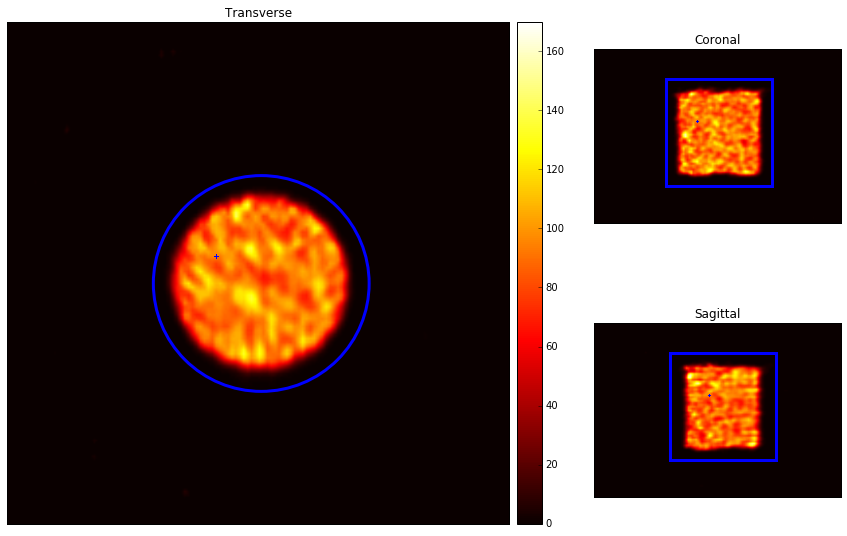

Results of SUV calculation:
  - Nb of counts in the image: 48806196
  - Delay between injection and scan:  -3861.15  hours
  - Calculated SUV factor:  0.0  cps/MBq


In [12]:
# MAIN INTERFACE #

# Displays SUV calculation results
def dispResults():
    nbcnts = calc_nbOfCounts(m_img, nb_pixel_x, nb_pixel_y, nb_slices,roi[0], 
                         roi[1], roi[2], roi[3]+margeROI, roi[4]+(2*margeROI))
    suvFactor = calcSUVfactor(nbcnts, Ainj, Tinj, Ares, Tres, acq_datetime, 
                          frame_duration*nb_angular_steps, T1demi, 
                          nb_detectors, scan_arc)
    print 'Results of SUV calculation:'
    print '  - Nb of counts in the image: ' + str(int(nbcnts))
    print '  - Delay between injection and scan: ', round((acq_datetime-Tinj).total_seconds()/3600.0, 2), ' hours'
    print '  - Calculated SUV factor: ', str(round(suvFactor,2)), ' cps/MBq'

    
# Draws circle centers
def redrawCenters():
    line1a[0].set_xdata([xslider.value-1,xslider.value+1])
    line1a[0].set_ydata([zslider.value,zslider.value])
    line1b[0].set_xdata([xslider.value,xslider.value])
    line1b[0].set_ydata([zslider.value-1,zslider.value+1])
    line2a[0].set_xdata([yslider.value-1,yslider.value+1])
    line2a[0].set_ydata([zslider.value,zslider.value])
    line2b[0].set_xdata([yslider.value,yslider.value])
    line2b[0].set_ydata([zslider.value-1,zslider.value+1])
    line3a[0].set_xdata([xslider.value-1,xslider.value+1])
    line3a[0].set_ydata([yslider.value,yslider.value])
    line3b[0].set_xdata([xslider.value,xslider.value])
    line3b[0].set_ydata([yslider.value-1,yslider.value+1])
        
def refreshPlot(b):    
    minv = minslider.value
    maxv = maxslider.value
    if (minv>maxv):
        print "Erreur: min > max"
    else:
        im1.set_data(m_img[:,yslider.value,:])
        im1.set_clim(vmin=minv, vmax=maxv)
        im2.set_data(m_img[:,:,xslider.value])
        im2.set_clim(vmin=minv, vmax=maxv)
        im3.set_data(m_img[zslider.value,:,:])
        im3.set_clim(vmin=minv, vmax=maxv)
    redrawCenters()
    display.clear_output(wait=True)
    display.display(fig)
    dispResults()
  
# Plot size
plt.rcParams['figure.figsize'] = (15,9)

# Reads the image:
m_img = ds.pixel_array[:,:,:].astype(np.float32) * rescaleSlope + rescaleIntercept

# min, max of main image:
_min, _max = np.amin(m_img), np.amax(m_img)

# Ipywidgets:
minslider  = FloatSlider(value=_min, min=_min, max=_max, 
                         step=(_max-_min)/100, description='min', width='40%')
maxslider  = FloatSlider(value=_max, min=_min, max=_max*1.5, 
                         step=(_max-_min)/100, description='max', width='40%')

xslider = IntSlider(value=int(nb_pixel_x/2), min=0, max=nb_pixel_x-1, 
                    step=1, description="x",width='40%')
yslider = IntSlider(value=int(nb_pixel_y/2), min=0, max=nb_pixel_y-1, 
                    step=1, description="y",width='40%')
zslider = IntSlider(value=int(nb_slices/2), min=0, max=nb_slices-1, 
                    step=1, description="z",width='40%')

refresh_button = Button(description="Refresh!", width='30%') #, height='100px'
refresh_button.on_click(refreshPlot)

items1 = [
    Label(value="Visualization window:", width='90%'),
    minslider,
    maxslider,
    Label(value=". ", width='90%'),
    Label(value="View slices", width='90%'),
    xslider,
    yslider,
    zslider,
    Label(value=". ", width='90%'),
 ]
items2 = [
    refresh_button,
]

box1 = Box(children=items1, layout=box_layout_std)
box2 = Box(children=items2, layout=box_layout_right)
display.display(box1)
display.display(box2)

# Plots the images:
fig = plt.figure()
gs = gridspec.GridSpec(2, 3)

max_pos = ndimage.measurements.maximum_position(m_img)
xslider.value = max_pos[2]
yslider.value = max_pos[1]
zslider.value = max_pos[0]

ax1 = fig.add_subplot(gs[0,2])
im1 = ax1.imshow(m_img[:,yslider.value,:], cmap="hot", vmin = _min, vmax = _max)
ax1.set_title('Coronal')
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.axes.autoscale(False)

ax2 = fig.add_subplot(gs[1,2])
im2 = ax2.imshow(m_img[:,:,xslider.value], cmap="hot", vmin = _min, vmax = _max)
ax2.set_title('Sagittal')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.autoscale(False)

ax3 = fig.add_subplot(gs[:,:-1])
im3 = ax3.imshow(m_img[zslider.value,:,:], cmap="hot", vmin = _min, vmax = _max)
ax3.set_title('Transverse')
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax3.axes.autoscale(False)

roi = findPhantom(m_img, nb_pixel_x, nb_pixel_y, nb_slices, thresholdPhantom)

try:
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im3, cax=cax3)
    line1a = ax1.axes.plot([xslider.value-1,xslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line1b = ax1.axes.plot([xslider.value,xslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line2a = ax2.axes.plot([yslider.value-1,yslider.value+1], 
                  [zslider.value,zslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line2b = ax2.axes.plot([yslider.value,yslider.value], 
                  [zslider.value-1,zslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    line3a = ax3.axes.plot([xslider.value-1,xslider.value+1], 
                  [yslider.value,yslider.value], 
                  color='blue', linestyle='-', linewidth=1)
    line3b = ax3.axes.plot([xslider.value,xslider.value], 
                  [yslider.value-1,yslider.value+1], 
                  color='blue', linestyle='-', linewidth=1)
    c1 = plt.Circle((roi[0], roi[1]), roi[3]+margeROI, fill=False, 
                      color='blue', linewidth=3)
    ax3.axes.add_patch(c1)
    r1 = plt.Rectangle((roi[0]-roi[3]-margeROI, roi[2]-roi[4]/2-margeROI), 
                      (roi[3]+margeROI)*2, roi[4]+2*margeROI, fill=False, 
                      color='blue', linewidth=3)
    ax1.axes.add_patch(r1)
    r2 = plt.Rectangle((roi[1]-roi[3]-margeROI, roi[2]-roi[4]/2-margeROI), 
                      (roi[3]+margeROI)*2, roi[4]+2*margeROI, fill=False, 
                      color='blue', linewidth=3)
    ax2.axes.add_patch(r2)
except Error: 
    print 'Error!'

dispResults()




# Remarks:

